In [2]:
from pathlib import Path
import pickle
import sqlite3
from contextlib import closing
from time import time
import pandas as pd
import csv
import numpy as np
import math
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

sql_file = "all_txs.sql"

In [3]:
# Executes the provided query using the sqlite database in the file specified by sql_file.
# Automatically commits changes and closes the connection and cursor when done.
def query(query, sql_file=sql_file):
    # Create a connection and cursor for the sqlite file
    with closing(sqlite3.connect(sql_file)) as conn: # auto-closes the connection
        with conn, closing(conn.cursor()) as cur:    # auto-commits connection and auto-closes cursor
            cur.execute(query)
            return cur.fetchall()

In [4]:
#!!!!!!!!!
# Older version, DOES NOT WORK after changes to Load_Transactions.ipynb
# Gets the price to weight ratio (gas price) for all pending transactions
def get_ratios_OLD(block_number):
    # Get the base fee
    baseFee_query = query(f"SELECT baseFeePerGas FROM blocks WHERE blockNumber == {block_number} LIMIT 1")
    
    # If nothing was returned, we don't know this block number
    if len(baseFee_query) == 0:
        raise ValueError('No block with this number in blocks table!')
    else:
        baseFee = float(baseFee_query[0][0])
    
    # Get the gas prices, and return them
    query_list = query( f'''SELECT hash, maxFeePerGas, maxPriorityFeePerGas, gasPrice 
                            FROM pending_txs
                            WHERE lastBlock == {block_number}''')
    ratios = {tx_hash: min(baseFee + priorityFee, maxFee) if maxFee is not None else gasPrice
              for tx_hash, maxFee, priorityFee, gasPrice in query_list}
    return ratios

# Gets the weight (total gas required) for all pending transactions
def get_weights_OLD(block_number):
    # Get the gas used for each pending transaction from the txs and/or confirmed_pending_txs tables
    '''query_list = query(f"WITH stage AS (SELECT * from pending_txs " +
                                            f"WHERE pending_txs.lastBlock == {block_number}) " +
                            "SELECT stage.hash, txs.gasUsed, confirmed_pending_txs.gasUsed, stage.gasLimit " +
                            "FROM (stage LEFT JOIN txs on stage.hash = txs.hash) " +
                               "LEFT JOIN confirmed_pending_txs on stage.hash = confirmed_pending_txs.hash ")'''
    query_list = query( f'''WITH stage AS (
                                SELECT * from pending_txs
                                WHERE pending_txs.lastBlock == {block_number}
                            SELECT hash, minGasUsed
                            FROM stage LEFT JOIN pending_txs_gas ON stage.hash = pending_txs_gas.hash''')
    
    # Get the weights. Set to None if gasUsed is missing from both the txs and confirmed_pending_txs
    # tables, otherwise one of those if gasUsed is in one table and not the other, otherwise the
    # minimum of the two if it is present in both tables.
    weights = {tx_hash: pick_tx_weight(weight_txs, weight_confirmed, gas_limit) for tx_hash, weight_txs, weight_confirmed, gas_limit in query_list}
    
    # query_list = query(f"SELECT hash, gasLimit FROM pending_txs WHERE lastBlock == {block_number}")
    # weights = {tx_hash: weight for tx_hash, weight in query_list}
    
    return weights

# Returns pending transactions, including the hash, price-to-weight ratio, and weight, sorted
# by the price-to-weight ratio
def get_pending_txs_OLD(block_number, verbose=False):
    if verbose:
        start_time = time()
        
    # Get the price-to-weight ratios (gas prices) of all pending transactions
    if verbose:
        print("Getting price-to-weight ratios...")
    ratios = get_ratios_OLD(block_number)
    
    # Get the weights (gas amounts) of all pending transactions
    if verbose:
        print("Getting weights...")
    weights = get_weights_OLD(block_number)
    
    # Put the list of pending transactions together, and sort by price-to-weight ratio.
    # Only considers pending transactions that have both a ratio and a weight.
    if verbose:
        print("Sorting by weight...")
    tx_hashes = set(ratios.keys()).intersection(weights.keys())
    pending_txs = [(tx_hash, ratios[tx_hash], weights[tx_hash]) for tx_hash in tx_hashes]
    pending_txs = sorted(pending_txs, key = lambda x: x[1], reverse=True)
    
    if verbose:
        end_time = time()
        print(f"Found {len(pending_txs)} pending txs in {end_time - start_time:.2f}s")
    
    return pending_txs

In [5]:
# Returns pending transactions, including the hash, price-to-weight ratio, and weight, sorted
# by the price-to-weight ratio
def get_pending_txs(block_number, belowGasLimit=False, includeMinedTxs=False, verbose=False):
    if verbose:
        print('Getting transactions...')
        start_time = time()
        
    # Get the pending transactions
    query_str = f'''SELECT hash, gasPrice, gasUsed
                    FROM pending_txs
                    WHERE lastBlock = {block_number}'''
    
    # We only want transactions that used less gas than the gas limit, i.e., that were ever
    # actually mined
    if belowGasLimit:
        query_str += ' AND gasUsed < gasLimit'
    
    # We want to include transactions that were not public but that the miner packed in the
    # block, i.e., they had some private access to these transactions
    if includeMinedTxs:
        query_str += f''' UNION
                          SELECT hash, gasPrice, gasUsed
                          FROM txs
                          WHERE blockNumber = {block_number}'''

    # Run the query
    query_list = query(query_str)
    
    # Put the list of pending transactions together, and sort by price-to-weight ratio.
    if verbose:
        print("Sorting by price-to-weight ratio...")
    pending_txs = [(tx_hash, price_ratio, weight) for (tx_hash, price_ratio, weight) in query_list]
    pending_txs = sorted(pending_txs, key = lambda x: x[1], reverse=True)
    
    if verbose:
        end_time = time()
        print(f"Found {len(pending_txs)} pending txs in {end_time - start_time:.2f}s")
    
    return pending_txs

In [6]:
# Use the greedy algorithm to pack transactions into a block. Sort the pending transactions
# by price-to-weight ratio (gas price), then pack by weight until full. Once a transaction
# no longer fits in the block, continue moving down the sorted list until the block is full
# or there are no more pending transactions to consider.
# For each
def greedy_packing(pending_txs, block_number, verbose=False):
    # If verbose, compute total elapsed time
    if verbose:
        start_time = time()
    
    # Get the smallest weight of any transaction
    min_weight = np.min([x[2] for x in pending_txs])
    
    # Get the gas limit for this block
    gasLimit_query = query(f"SELECT gasLimit FROM blocks WHERE blockNumber == {block_number}")
    gasLimit = float(gasLimit_query[0][0])
    
    # Start packing transactions
    tx_packed = []
    gas_packed = 0
    
    # Pack the block until it is full or we have considered all transactions
    for tx_hash, ratio, weight in pending_txs:
        # If there is room, pack this transaction, along with the profit it produced
        if gas_packed + weight <= gasLimit:
            tx_packed.append((tx_hash, ratio * weight, ratio, weight))
            gas_packed += weight
            
            # If the block cannot fit any more transactions, stop packing
            if gas_packed > gasLimit - min_weight:
                break
    
    if verbose:
        end_time = time()
        revenue_query = query(f"SELECT minerRevenue FROM blocks WHERE blockNumber == {block_number}")
        revenue = float(revenue_query[0][0]) * 10**(-18)
        earned_revenue = sum([x[1] for x in tx_packed]) * 10**(-18)
        print(f"Packed {len(tx_packed)} txs in {end_time - start_time:.2f}s for revenue of {earned_revenue :0.5f} ETH ({(earned_revenue - revenue)/revenue*100:.2f}% increase over {revenue:0.5f} ETH), " +
              f"using {gas_packed} of max {int(gasLimit)} gas (wasted {int(gasLimit) - gas_packed} gas, i.e., {(gasLimit - gas_packed) / gasLimit * 100 :.2f}%)")
        
    return tx_packed

In [7]:
# Use dynamic programming to pack transactions into a block. Following pseudocode from
# page 14 of https://www.es.ele.tue.nl/education/5MC10/Solutions/knapsack.pdf
def DP_packing(pending_txs, block_number, weight_factor=1, verbose=False):
    # If verbose, compute total elapsed time
    if verbose:
        start_time = time()
    
    # Get the smallest weight of any transaction
    min_weight = np.min([x[2] for x in pending_txs])
    
    # Get the gas limit for this block
    gasLimit_query = query(f"SELECT gasLimit FROM blocks WHERE blockNumber == {block_number}")
    gasLimit_unweighted = int(gasLimit_query[0][0])
    gasLimit = math.floor(gasLimit_unweighted / weight_factor)
    
    ### DYNAMIC PROGRAMMING ###
    # For keeping track of total value packed
    V = np.zeros((gasLimit + 1,))
    V_old = np.zeros((gasLimit + 1,))
    # For keeping track of which transactions are packed
    keep = np.full((len(pending_txs), gasLimit + 1), False, dtype=bool)
    num_txs = len(pending_txs)
    
    if verbose:
        print(f"Finding best packing with {num_txs} txs for weight limit {gasLimit} (weight reduction factor {weight_factor})")
    
    # Loop through all pending transactions
    for tx_ind in tqdm(range(0, num_txs)):
        # Store weight and revenue of the transactions
        tx_weight = int(math.ceil(pending_txs[tx_ind][2] / weight_factor))
        tx_value = tx_weight * pending_txs[tx_ind][1]
        
        # Loop through all possible weights
        for w in range(tx_weight, gasLimit + 1):
            # If this transaction fits, update total value
            if tx_value + V_old[w - tx_weight] > V_old[w]:
                # If including this transaction results in a larger value, include it.
                # Otherwise, we can do no worse than we did before.
                V[w] = tx_value + V_old[w - tx_weight]
                keep[tx_ind, w] = True
        # On to the next iteration, so set V_{i-1}
        V_old = np.copy(V)
        
    # Now that we have the best packing's value, find the transactions that belong in this packing
    tx_packed = []
    gas_packed = 0
    gas_packed_unweighted = 0
    
    for tx_ind in range(num_txs - 1, -1, -1):
        if keep[tx_ind, gasLimit - gas_packed]:
            tx_hash, ratio, weight = pending_txs[tx_ind]
            tx_packed.append((tx_hash, ratio * weight, ratio, weight))
            gas_packed += int(math.ceil(weight / weight_factor))
            gas_packed_unweighted += weight
    
    if verbose:
        end_time = time()
        revenue_query = query(f"SELECT minerRevenue FROM blocks WHERE blockNumber == {block_number}")
        revenue = float(revenue_query[0][0]) * 10**(-18)
        earned_revenue = sum([x[1] for x in tx_packed]) * 10**(-18)
        print(f"Packed {len(tx_packed)} txs in {end_time - start_time:.2f}s for revenue of {earned_revenue :0.5f} ETH ({(earned_revenue - revenue)/revenue*100:.2f}% increase over {revenue:0.5f} ETH), " +
              f"using {gas_packed_unweighted} of max {int(gasLimit_unweighted)} gas (wasted {int(gasLimit_unweighted) - gas_packed_unweighted} gas, i.e., {(gasLimit_unweighted - gas_packed_unweighted) / gasLimit_unweighted * 100 :.2f}%)")

        
    return tx_packed

In [8]:
# Use dynamic programming to pack transactions into a block. Following pseudocode sent on Slack by Sanjeev
def DP_v2_packing(pending_txs, block_number, weight_factor=1, verbose=False):
    # If verbose, compute total elapsed time
    if verbose:
        start_time = time()
    
    # Get the smallest weight of any transaction
    min_weight = np.min([x[2] for x in pending_txs])
    
    # Get the gas limit for this block
    gasLimit_query = query(f"SELECT gasLimit FROM blocks WHERE blockNumber == {block_number}")
    gasLimit = int(gasLimit_query[0][0])
    
    ### DYNAMIC PROGRAMMING ###
    # Get an estimate of total profit of items via greedy
    tx_packed_greedy = greedy_packing(pending_txs, block_number, verbose=False)
    max_profit = int(math.ceil(sum([x[1] for x in tx_packed_greedy]) * 1.5 / weight_factor))
    if verbose:
        print(f"Greedy achieved profit of {int(math.ceil(sum([x[1] for x in tx_packed_greedy])))}")
    
    # For keeping track of total value packed
    T = np.zeros((max_profit + 1,))
    T_old = np.full((max_profit + 1,), np.Inf)
    # For keeping track of which transactions are packed
    # keep = np.full((len(pending_txs), max_profit + 1), False, dtype=bool)
    num_txs = len(pending_txs)
    
    if verbose:
        print(f"Finding best packing with {num_txs} txs for max profit {max_profit} (weight reduction factor {weight_factor})")
    
    # Loop through all pending transactions
    for tx_ind in tqdm(range(0, num_txs)):
        # Store weight and revenue of the transactions
        tx_weight = pending_txs[tx_ind][2]
        tx_value = int(math.floor((tx_weight * pending_txs[tx_ind][1]) / weight_factor))
        
        # Loop through all possible weights
        for p in range(tx_value, max_profit + 1):
            # If this transaction fits, update total value
            if tx_weight + T[p - tx_value] < T_old[p]:
                # If including this transaction results in a larger value, include it.
                # Otherwise, we can do no worse than we did before.
                T[p] = tx_weight + T[p - tx_value]
                # keep[tx_ind, p] = True
        # On to the next iteration, so set V_{i-1}
        T_old = np.copy(T)
    
    # Find the optimal value
    optimal_profit = 0
    for p in range(0, max_profit+1):
        if T[p] <= gasLimit:
            optimal_profit = p            
            
    if verbose:
        end_time = time()
        # print(f"Packed in {end_time - start_time:.2f}s for revenue of {optimal_profit * 10**(-18) :0.5f} ETH")
        revenue_query = query(f"SELECT minerRevenue FROM blocks WHERE blockNumber == {block_number}")
        revenue = float(revenue_query[0][0]) * 10**(-18)
        earned_revenue = optimal_profit * weight_factor * 10**(-18)
        gas_packed = T[optimal_profit]
        print(f"Packed in {end_time - start_time:.2f}s for revenue of {earned_revenue :0.5f} ETH ({(earned_revenue - revenue)/revenue*100:.2f}% increase over {revenue:0.5f} ETH), " +
              f"using {gas_packed} of max {int(gasLimit)} gas (wasted {int(gasLimit) - gas_packed} gas, i.e., {(gasLimit - gas_packed) / gasLimit * 100 :.2f}%)")

    return optimal_profit * weight_factor
    '''
    # Now that we have the best packing's value, find the transactions that belong in this packing
    tx_packed = []
    profit_packed = 0
    gas_packed_unweighted = 0
    
    for tx_ind in range(num_txs - 1, -1, -1):
        if keep[tx_ind, max_profit - profit_packed]:
            tx_hash, ratio, weight = pending_txs[tx_ind]
            tx_packed.append((tx_hash, ratio * weight))
            profit_packed += int(math.ceil((ratio * weight) / weight_factor))
            gas_packed_unweighted += weight
    
    if verbose:
        end_time = time()
        print(f"Packed {len(tx_packed)} txs in {end_time - start_time:.2f}s for revenue of {sum([x[1] for x in tx_packed]) * 10**(-18) :0.5f} ETH, " +
              f"using {gas_packed_unweighted} of max {gasLimit_unweighted} gas (wasted {gasLimit_unweighted - gas_packed_unweighted} gas, i.e., {(gasLimit_unweighted - gas_packed_unweighted) / gasLimit_unweighted * 100 :.2f}%)")
    
    return tx_packed
    '''

In [9]:
# Compare the packings of greedy and DP for a given random sample size
def compare_packings(sample_size, num_trials, weight_factors, verbose=False):
    DP_vals = np.zeros((len(weight_factors), num_trials))
    greedy_vals = np.zeros((num_trials,))
    
    for t in range(num_trials):
        # Pick the random sample of pending transactions
        random_pending = random.sample(pending_txs, sample_size)
        
        # Greedy packing
        tx_packed_greedy = greedy_packing(random_pending, block_number, verbose=verbose)
        greedy_vals[t] = sum([x[1] for x in tx_packed_greedy]) * 10**-18
        
        # DP packing
        for i in range(len(weight_factors)):
            w = weight_factors[i]

            tx_packed_DP = DP_packing(random_pending, block_number, weight_factor=w, verbose=verbose)
            val_DP = sum([x[1] for x in tx_packed_DP]) * 10**-18
            DP_vals[i, t] = val_DP
            # DP_improvement_ratios[i, t] = (val_DP - greedy_vals[t]) / greedy_vals[t] * 100
            
    # Return the percentage increase of value packed by the DP algorithm
    return DP_vals, greedy_vals

In [10]:
# Compare the packings of greedy and DP for a given block
def compare_block_packings(block_number, weight_factors, belowGasLimit=False, includeMinedTxs=False, verbose=False):
    # For storing the results
    results_dict = {}
    
    # Get the pending transactions, as well as their weight and price-to-weight ratio
    pending_txs = get_pending_txs(block_number, belowGasLimit=belowGasLimit,
                                  includeMinedTxs=includeMinedTxs, verbose=verbose)
    
    # Determine the value earned by the miner of the block
    revenue_query = query(f"SELECT minerRevenue FROM blocks WHERE blockNumber = {block_number}")
    revenue = float(revenue_query[0][0]) * 10**(-18)
    results_dict['miner'] = {'value': revenue}
    
    # Determine which transactions were actually packed in this block, and how many were ever available
    # as pending transactions
    real_txs = query(f'SELECT DISTINCT hash, gasUsed, gasPrice FROM txs WHERE blockNumber = {block_number}')
    results_dict['num_real_txs'] = len(real_txs)
    seen_txs = query(f'''SELECT DISTINCT txs.hash, txs.gasUsed
                         FROM txs
                             JOIN pending_txs
                             ON txs.hash = pending_txs.hash
                         WHERE blockNumber = {block_number}
                         AND lastBlock <= {block_number}''')
    results_dict['num_seen_real'] = len(seen_txs)
    
    # Percentage of transactions that were never in pending pool
    results_dict['pct_seen_txs'] = 0 if len(real_txs) == 0 else len(seen_txs) / len(real_txs) * 100
    
    # Percentage of the total weight of this block that is filled by transactions that were
    # never in the pending pool
    weight_in_pool = sum([s[1] for s in seen_txs])
    total_weight = sum([r[1] for r in real_txs])
    results_dict['pct_seen_by_weight'] = 0 if total_weight == 0 else weight_in_pool / total_weight * 100
    
    # Revenue earned in this block that came from transactions that were never in the pending pool
    seen_set = set([s[0] for s in seen_txs])
    results_dict['revenue_from_unseen'] = sum([r[1] * r[2] if r[0] in seen_set else 0 for r in real_txs])
    
    # Determine the gas limit of the block
    gasLimit_query = query(f'SELECT gasLimit FROM blocks WHERE blockNumber = {block_number}')
    gasLimit = int(gasLimit_query[0][0])
    
    # Find the total weight and value of all pending transactions
    total_weight = sum([x[2] for x in pending_txs])
    total_value = sum([x[1]*x[2] for x in pending_txs])
    
    # Check if all transactions could fit in the block. If they do, we do not need to run any packings.
    if total_weight < gasLimit:
        if verbose:
            print('Skipped packing (all pending transactions fit in the block)')
        results_dict['greedy'] = {'tx_packed': pending_txs, 'value': total_value, 'time': None}
        results_dict['DP'] = {}
        for w in weight_factors:
            results_dict['DP'][w] = {'tx_packed': pending_txs, 'value': total_value, 'time': None}
    else:
        # Run greedy packing
        start_time = time()
        tx_packed_greedy = greedy_packing(pending_txs, block_number, verbose=verbose)
        time_greedy = time() - start_time
        val_greedy = sum([x[1] for x in tx_packed_greedy]) * 10**-18
        results_dict['greedy'] = {'tx_packed': tx_packed_greedy, 'value': val_greedy, 'time': time_greedy}

        # Run DP packing for each given weight factor, saving results independently
        results_dict['DP'] = {}
        for w in weight_factors:
            start_time = time()
            tx_packed_DP = DP_packing(pending_txs, block_number, weight_factor=w, verbose=verbose)
            time_DP = time() - start_time
            val_DP = sum([x[1] for x in tx_packed_DP]) * 10**-18
            results_dict['DP'][w] = {'tx_packed': tx_packed_DP, 'value': val_DP, 'time': time_DP}
        
    return results_dict

In [11]:
# Plot the results of the comparative block packings
def plot_block_comparison(results):
    # For plotting
    block_numbers = list(results.keys())
    weight_factors = [100, 1000] #sorted(results[block_numbers[0]]['DP'].keys(), reverse=True)
    fig, ax = plt.subplots(2,3)
    ax0 = ax[0,0]
    ax1 = ax[1,2]
    ax2 = ax[1,0]
    ax3 = ax[0,2]
    ax4 = ax[0,1]
    ax5 = ax[1,1]
    fig.set_size_inches(18.5, 10.5)
    x_plot = np.arange(len(block_numbers))
    hist_bins = 10
    
    # Results of greedy packing
    miner_val = np.array([r['miner']['value'] * 10**-18 for r in results.values()])
    miner_nonzero = miner_val > 0
    x_nonzero = np.arange(sum(miner_nonzero))
    greedy_val = np.array([r['greedy']['value'] * 10**-18 for r in results.values()])
    greedy_time = np.array([r['greedy']['time'] for r in results.values()])
    greedy_diff = greedy_val - miner_val
    greedy_pct = greedy_diff[miner_nonzero] / miner_val[miner_nonzero] * 100
    greedy_hist, hist_edges = np.histogram(greedy_diff, bins=hist_bins)
    hist_width = [(hist_edges[i+1] - hist_edges[i]) / (len(weight_factors) + 1)
                  for i in range(len(hist_edges) - 1)]
    hist_plot = hist_edges[:-1]
    inds_sorted = list(np.argsort(greedy_diff))
    inds_nonzero = list(np.argsort(greedy_pct))
    
    # Plot a flat line at zero
    ax0.plot(x_plot, np.zeros(x_plot.shape), '--k')
    ax4.plot(x_nonzero, np.zeros(x_nonzero.shape), '--k')

    # For the greedy difference
    DP_greedy_diff = [(r['DP'][min(weight_factors)]['value'] - r['greedy']['value'])
                      for r in results.values()]
    inds_DP_sorted = list(np.argsort(DP_greedy_diff))
    
    # For each weight factor, plot the DP packing result with that weight factor
    for w in weight_factors:
        DP_val = np.array([r['DP'][w]['value'] * 10**-18 for r in results.values()])
        DP_time = np.array([r['DP'][w]['time'] for r in results.values()])
        DP_diff = DP_val - miner_val
        DP_pct = DP_diff[miner_nonzero] / miner_val[miner_nonzero] * 100
        DP_hist, _ = np.histogram(DP_diff, bins=hist_edges)
        DP_greedy_diff = DP_val - greedy_val
        DP_greedy_pct = DP_greedy_diff / greedy_val * 100
        # ax0.plot(x_plot, [DP_val[i] - greedy_val[i] for i in range(len(DP_val))], label=f'DP {w}')
        ax0.plot(x_plot, DP_diff[inds_sorted], label=f'DP {w}')
        ax4.plot(x_nonzero, DP_pct[inds_nonzero], label=f'DP {w}')
        ax1.plot(x_plot, DP_time[inds_sorted], label=f'DP {w}')
        ax2.plot(x_plot, DP_greedy_diff[inds_DP_sorted], label=f'DP {w}')
        ax5.plot(x_plot, DP_greedy_pct[inds_DP_sorted], label=f'DP {w}')
        ax3.bar(hist_plot, DP_hist, width=hist_width, label=f'DP {w}')
        hist_plot += hist_width
        
    # Plot greedy results
    ax0.plot(x_plot, greedy_diff[inds_sorted], label='Greedy')
    ax4.plot(x_nonzero, greedy_pct[inds_nonzero], label='Greedy')
    ax1.plot(x_plot, greedy_time[inds_sorted], label='Greedy')
    ax3.bar(hist_plot, greedy_hist, width=hist_width, label='Greedy')
    
    # Plot the miner's revenues
    # miner_val = [r['miner']['value'] for r in results.values()]
    # ax0.plot(x_plot, miner_val, label='Miner')
        
    # ax0.set_xticks(x_plot)
    # ax0.set_xticklabels(x_plot / 10)
    # ax0.set_title('Difference in value of packed transactions from greedy (higher is better)')
    # ax0.set_ylabel('Difference')
    ax0.set_title('Difference from Miner Revenue')
    ax0.set_xlabel('Block (ordered by greedy difference)')
    ax0.set_ylabel('Difference (ETH)')
    ax0.legend()
    
    ax4.set_title('Percent difference from Miner Revenue')
    ax4.set_xlabel('Block (ordered by greedy % difference)')
    ax4.set_ylabel('Difference (%)')
    ax4.set_yscale('log')
    ax4.legend() 
    
    # ax1.set_xticks(x_plot)
    # ax1.set_xticklabels(x_plot / 10)
    ax1.set_title('Time to find packing')
    ax1.set_xlabel('Block (ordered by greedy difference)')
    ax1.set_ylabel('Time (s)')
    ax1.set_yscale('log')
    ax1.legend()
    
    ax2.set_title('Difference from Greedy Revenue')
    ax2.set_xlabel(f'Block (ordered by DP {min(weight_factors)} difference)')
    ax2.set_ylabel('Difference (ETH)')
    ax2.legend()
    
    ax5.set_title('Percent difference from Greedy Revenue')
    ax5.set_xlabel(f'Block (ordered by DP {min(weight_factors)} difference)')
    ax5.set_ylabel('Difference (%)')
    # ax5.set_yscale('symlog')
    ax5.legend()
    
    ax3.set_title('Difference from Miner Revenue')
    ax3.set_xlabel('Difference (ETH)')
    ax3.set_ylabel('# Blocks')
    ax3.set_yscale('log')
    ax3.legend()
    
    fig.tight_layout()
    plt.show()
    
    # print(f'''For blocks where the miner included transactions, greedy produced higher revenue {sum(greedy_val > miner_val)/len(miner_val)*100:.0f}% of the time, with an average increase of {np.mean(greedy_diff):.3f} ETH / {np.mean(greedy_pct):.1f}% per block. It took {np.mean(greedy_time):.3f}s on average.''')
    DP_val = np.array([r['DP'][min(weight_factors)]['value'] for r in results.values()])
    DP_diff = DP_val - miner_val
    DP_pct = DP_diff[miner_nonzero] / miner_val[miner_nonzero] * 100
    DP_time = np.array([r['DP'][min(weight_factors)]['time'] for r in results.values()])
    # print(f'''For blocks where the miner included transactions, the best DP produced higher revenue {sum(DP_val > miner_val)/len(miner_val)*100:.0f}% of the time, with an average increase of {np.mean(DP_val - miner_val):.3f} ETH / {np.mean(DP_pct):.1f}% per block. It took {np.mean(DP_time):.1f}s on average.''')

In [12]:
# Get all blocks where we have transactions in the mempool, details about the block, and the 
# transactions that the actual miner put in the block.
pending_blocks_result = query('''SELECT DISTINCT lastBlock
                                 FROM pending_txs 
                                 INNER JOIN blocks
                                     ON pending_txs.lastBlock = blocks.blockNumber
                                 INNER JOIN txs
                                     ON pending_txs.lastBlock = txs.blockNumber
                                 ORDER BY lastBlock''')
pending_blocks = [x[0] for x in pending_blocks_result]
print(len(pending_blocks))
print(pending_blocks)

164
[15171056, 15173222, 15173227, 15173231, 15173234, 15173236, 15173237, 15173241, 15173246, 15173247, 15173252, 15173260, 15173261, 15173263, 15173264, 15173265, 15173266, 15173269, 15173272, 15173274, 15173276, 15173278, 15173281, 15173282, 15173283, 15173284, 15173287, 15173291, 15173295, 15173296, 15173300, 15173305, 15173306, 15173307, 15173308, 15173314, 15173315, 15173316, 15173321, 15173322, 15173324, 15173329, 15173330, 15173331, 15173339, 15173340, 15173341, 15173347, 15173349, 15173351, 15173352, 15173354, 15173363, 15173365, 15173366, 15173374, 15173379, 15173382, 15173383, 15173394, 15173398, 15173401, 15173408, 15173414, 15173416, 15173419, 15173427, 15173429, 15173432, 15173434, 15173438, 15173441, 15173442, 15173452, 15173457, 15173458, 15173461, 15173462, 15173467, 15173470, 15173472, 15173474, 15173481, 15173485, 15173486, 15173491, 15173493, 15173504, 15173505, 15173508, 15173512, 15173515, 15173519, 15173524, 15173526, 15173528, 15173530, 15173534, 15173537, 15173

In [68]:
results = {}
block_numbers = pending_blocks
num_blocks = len(block_numbers)
count = 1

for block_number in block_numbers:
    print(f'Working on block {block_number} ({count}/{num_blocks})')
    count += 1
    results[block_number] = compare_block_packings(block_number, weight_factors, belowGasLimit=True,
                                                   includeMinedTxs=True, verbose=False)

Working on block 15171056 (1/164)


100%|██████████| 990/990 [00:17<00:00, 56.45it/s]


Working on block 15173222 (2/164)


100%|██████████| 407/407 [00:09<00:00, 42.64it/s]


Working on block 15173227 (3/164)


100%|██████████| 428/428 [00:12<00:00, 33.27it/s]


Working on block 15173231 (4/164)
Working on block 15173234 (5/164)
Working on block 15173236 (6/164)
Working on block 15173237 (7/164)
Working on block 15173241 (8/164)


100%|██████████| 369/369 [00:11<00:00, 32.76it/s]


Working on block 15173246 (9/164)
Working on block 15173247 (10/164)


100%|██████████| 332/332 [00:09<00:00, 33.29it/s]


Working on block 15173252 (11/164)
Working on block 15173260 (12/164)


100%|██████████| 527/527 [00:12<00:00, 43.38it/s]


Working on block 15173261 (13/164)


100%|██████████| 481/481 [00:12<00:00, 39.27it/s]


Working on block 15173263 (14/164)
Working on block 15173264 (15/164)
Working on block 15173265 (16/164)
Working on block 15173266 (17/164)


100%|██████████| 461/461 [00:13<00:00, 34.09it/s]


Working on block 15173269 (18/164)
Working on block 15173272 (19/164)
Working on block 15173274 (20/164)


100%|██████████| 519/519 [00:13<00:00, 38.40it/s]


Working on block 15173276 (21/164)
Working on block 15173278 (22/164)


100%|██████████| 321/321 [00:06<00:00, 49.29it/s]


Working on block 15173281 (23/164)


100%|██████████| 332/332 [00:08<00:00, 40.08it/s]


Working on block 15173282 (24/164)


100%|██████████| 627/627 [00:14<00:00, 43.85it/s]


Working on block 15173283 (25/164)


100%|██████████| 531/531 [00:13<00:00, 40.63it/s]


Working on block 15173284 (26/164)


100%|██████████| 742/742 [00:17<00:00, 42.81it/s]


Working on block 15173287 (27/164)


100%|██████████| 455/455 [00:11<00:00, 39.09it/s]


Working on block 15173291 (28/164)
Working on block 15173295 (29/164)
Working on block 15173296 (30/164)


100%|██████████| 380/380 [00:15<00:00, 23.90it/s]


Working on block 15173300 (31/164)
Working on block 15173305 (32/164)


100%|██████████| 379/379 [00:12<00:00, 31.23it/s]


Working on block 15173306 (33/164)


100%|██████████| 356/356 [00:10<00:00, 33.71it/s]


Working on block 15173307 (34/164)


100%|██████████| 367/367 [00:10<00:00, 36.13it/s]


Working on block 15173308 (35/164)


100%|██████████| 360/360 [00:07<00:00, 48.33it/s]


Working on block 15173314 (36/164)


100%|██████████| 299/299 [00:07<00:00, 41.64it/s]


Working on block 15173315 (37/164)


100%|██████████| 435/435 [00:10<00:00, 42.12it/s]


Working on block 15173316 (38/164)


100%|██████████| 653/653 [00:16<00:00, 39.43it/s]


Working on block 15173321 (39/164)


100%|██████████| 348/348 [00:10<00:00, 32.02it/s]


Working on block 15173322 (40/164)


100%|██████████| 396/396 [00:09<00:00, 41.57it/s]


Working on block 15173324 (41/164)


100%|██████████| 470/470 [00:13<00:00, 34.14it/s]


Working on block 15173329 (42/164)
Working on block 15173330 (43/164)


100%|██████████| 582/582 [00:15<00:00, 36.92it/s]


Working on block 15173331 (44/164)


100%|██████████| 586/586 [00:13<00:00, 42.30it/s]


Working on block 15173339 (45/164)
Working on block 15173340 (46/164)


100%|██████████| 664/664 [00:16<00:00, 39.18it/s]


Working on block 15173341 (47/164)


100%|██████████| 623/623 [00:15<00:00, 39.45it/s]


Working on block 15173347 (48/164)
Working on block 15173349 (49/164)
Working on block 15173351 (50/164)
Working on block 15173352 (51/164)


100%|██████████| 518/518 [00:12<00:00, 42.32it/s]


Working on block 15173354 (52/164)


100%|██████████| 692/692 [00:14<00:00, 48.35it/s]


Working on block 15173363 (53/164)


100%|██████████| 468/468 [00:14<00:00, 33.39it/s]


Working on block 15173365 (54/164)


100%|██████████| 298/298 [00:07<00:00, 38.72it/s]


Working on block 15173366 (55/164)


100%|██████████| 544/544 [00:13<00:00, 39.02it/s]


Working on block 15173374 (56/164)
Working on block 15173379 (57/164)


100%|██████████| 556/556 [00:13<00:00, 40.45it/s]


Working on block 15173382 (58/164)
Working on block 15173383 (59/164)


100%|██████████| 487/487 [00:12<00:00, 39.32it/s]


Working on block 15173394 (60/164)
Working on block 15173398 (61/164)
Working on block 15173401 (62/164)


100%|██████████| 313/313 [00:08<00:00, 36.87it/s]


Working on block 15173408 (63/164)


100%|██████████| 407/407 [00:11<00:00, 34.91it/s]


Working on block 15173414 (64/164)


100%|██████████| 291/291 [00:10<00:00, 27.69it/s]


Working on block 15173416 (65/164)


100%|██████████| 610/610 [00:14<00:00, 41.36it/s]


Working on block 15173419 (66/164)
Working on block 15173427 (67/164)
Working on block 15173429 (68/164)


100%|██████████| 494/494 [00:13<00:00, 37.57it/s]


Working on block 15173432 (69/164)


100%|██████████| 583/583 [00:15<00:00, 38.31it/s]


Working on block 15173434 (70/164)
Working on block 15173438 (71/164)
Working on block 15173441 (72/164)


100%|██████████| 306/306 [00:07<00:00, 42.64it/s]


Working on block 15173442 (73/164)


100%|██████████| 700/700 [00:15<00:00, 46.01it/s]


Working on block 15173452 (74/164)


100%|██████████| 569/569 [00:14<00:00, 38.20it/s]


Working on block 15173457 (75/164)
Working on block 15173458 (76/164)


100%|██████████| 349/349 [00:09<00:00, 37.16it/s]


Working on block 15173461 (77/164)


100%|██████████| 554/554 [00:15<00:00, 36.92it/s]


Working on block 15173462 (78/164)


100%|██████████| 550/550 [00:14<00:00, 37.89it/s]


Working on block 15173467 (79/164)


100%|██████████| 553/553 [00:14<00:00, 36.95it/s]


Working on block 15173470 (80/164)


100%|██████████| 277/277 [00:06<00:00, 39.83it/s]


Working on block 15173472 (81/164)


100%|██████████| 588/588 [00:19<00:00, 29.70it/s]


Working on block 15173474 (82/164)


100%|██████████| 471/471 [00:14<00:00, 32.75it/s]


Working on block 15173481 (83/164)


100%|██████████| 309/309 [00:08<00:00, 38.44it/s]


Working on block 15173485 (84/164)
Working on block 15173486 (85/164)


100%|██████████| 855/855 [00:18<00:00, 46.44it/s]


Working on block 15173491 (86/164)
Working on block 15173493 (87/164)


100%|██████████| 412/412 [00:10<00:00, 39.96it/s]


Working on block 15173504 (88/164)
Working on block 15173505 (89/164)


100%|██████████| 742/742 [00:16<00:00, 44.77it/s]


Working on block 15173508 (90/164)


100%|██████████| 343/343 [00:10<00:00, 33.60it/s]


Working on block 15173512 (91/164)


100%|██████████| 299/299 [00:07<00:00, 37.60it/s]


Working on block 15173515 (92/164)
Working on block 15173519 (93/164)
Working on block 15173524 (94/164)
Working on block 15173526 (95/164)


100%|██████████| 515/515 [00:13<00:00, 38.71it/s]


Working on block 15173528 (96/164)


100%|██████████| 486/486 [00:14<00:00, 34.16it/s]


Working on block 15173530 (97/164)
Working on block 15173534 (98/164)
Working on block 15173537 (99/164)
Working on block 15173543 (100/164)
Working on block 15173547 (101/164)
Working on block 15173548 (102/164)


100%|██████████| 750/750 [00:17<00:00, 42.63it/s]


Working on block 15173553 (103/164)


100%|██████████| 474/474 [00:14<00:00, 33.58it/s]


Working on block 15173554 (104/164)


100%|██████████| 416/416 [00:12<00:00, 34.66it/s]


Working on block 15173557 (105/164)
Working on block 15173560 (106/164)


100%|██████████| 390/390 [00:11<00:00, 32.99it/s]


Working on block 15173566 (107/164)


100%|██████████| 359/359 [00:10<00:00, 34.98it/s]


Working on block 15173568 (108/164)


100%|██████████| 489/489 [00:15<00:00, 32.41it/s]


Working on block 15173569 (109/164)


100%|██████████| 428/428 [00:10<00:00, 42.22it/s]


Working on block 15173575 (110/164)


100%|██████████| 420/420 [00:11<00:00, 35.51it/s]


Working on block 15173579 (111/164)


100%|██████████| 391/391 [00:11<00:00, 35.36it/s]


Working on block 15173585 (112/164)


100%|██████████| 401/401 [00:10<00:00, 37.21it/s]


Working on block 15173587 (113/164)


100%|██████████| 479/479 [00:11<00:00, 40.25it/s]


Working on block 15173592 (114/164)


100%|██████████| 460/460 [00:11<00:00, 39.84it/s]


Working on block 15173593 (115/164)


100%|██████████| 762/762 [00:19<00:00, 39.94it/s]


Working on block 15173596 (116/164)
Working on block 15173598 (117/164)


100%|██████████| 778/778 [00:18<00:00, 40.97it/s]


Working on block 15173599 (118/164)


100%|██████████| 909/909 [00:18<00:00, 49.97it/s]


Working on block 15173605 (119/164)
Working on block 15173609 (120/164)
Working on block 15173613 (121/164)
Working on block 15173617 (122/164)
Working on block 15173620 (123/164)
Working on block 15173621 (124/164)


100%|██████████| 552/552 [00:13<00:00, 40.67it/s]


Working on block 15173629 (125/164)


100%|██████████| 539/539 [00:14<00:00, 37.77it/s]


Working on block 15173635 (126/164)
Working on block 15173639 (127/164)
Working on block 15173648 (128/164)
Working on block 15173650 (129/164)


100%|██████████| 480/480 [00:10<00:00, 44.30it/s]


Working on block 15173655 (130/164)


100%|██████████| 679/679 [00:15<00:00, 42.87it/s]


Working on block 15173664 (131/164)
Working on block 15173665 (132/164)


100%|██████████| 732/732 [00:14<00:00, 49.09it/s]


Working on block 15173676 (133/164)


100%|██████████| 185/185 [00:05<00:00, 33.08it/s]


Working on block 15173680 (134/164)
Working on block 15173686 (135/164)


100%|██████████| 367/367 [00:09<00:00, 39.45it/s]


Working on block 15173691 (136/164)


100%|██████████| 530/530 [00:13<00:00, 38.39it/s]


Working on block 15173697 (137/164)
Working on block 15173701 (138/164)


100%|██████████| 313/313 [00:08<00:00, 38.24it/s]


Working on block 15173704 (139/164)


100%|██████████| 552/552 [00:14<00:00, 38.54it/s]


Working on block 15173707 (140/164)


100%|██████████| 473/473 [00:13<00:00, 35.34it/s]


Working on block 15173711 (141/164)
Working on block 15173713 (142/164)


100%|██████████| 512/512 [00:12<00:00, 39.39it/s]


Working on block 15173715 (143/164)


100%|██████████| 892/892 [00:20<00:00, 43.13it/s]


Working on block 15173716 (144/164)


100%|██████████| 1091/1091 [00:22<00:00, 48.10it/s]


Working on block 15173727 (145/164)


100%|██████████| 517/517 [00:14<00:00, 35.20it/s]


Working on block 15173729 (146/164)


100%|██████████| 371/371 [00:10<00:00, 35.27it/s]


Working on block 15173733 (147/164)
Working on block 15173734 (148/164)


100%|██████████| 811/811 [00:20<00:00, 39.62it/s]


Working on block 15173746 (149/164)


100%|██████████| 349/349 [00:09<00:00, 35.80it/s]


Working on block 15173757 (150/164)


100%|██████████| 553/553 [00:15<00:00, 34.95it/s]


Working on block 15173759 (151/164)


100%|██████████| 471/471 [00:10<00:00, 46.22it/s]


Working on block 15173775 (152/164)


100%|██████████| 364/364 [00:10<00:00, 34.95it/s]


Working on block 15173782 (153/164)


100%|██████████| 709/709 [00:17<00:00, 39.45it/s]


Working on block 15173787 (154/164)
Working on block 15173789 (155/164)


100%|██████████| 805/805 [00:19<00:00, 41.91it/s]


Working on block 15173796 (156/164)
Working on block 15173804 (157/164)
Working on block 15173810 (158/164)


100%|██████████| 650/650 [00:15<00:00, 42.74it/s]


Working on block 15173818 (159/164)


100%|██████████| 280/280 [00:07<00:00, 35.55it/s]


Working on block 15173825 (160/164)


100%|██████████| 343/343 [00:09<00:00, 37.59it/s]


Working on block 15173833 (161/164)


100%|██████████| 483/483 [00:13<00:00, 35.00it/s]


Working on block 15173835 (162/164)


100%|██████████| 641/641 [00:15<00:00, 40.60it/s]


Working on block 15173843 (163/164)


100%|██████████| 524/524 [00:14<00:00, 36.71it/s]


Working on block 15173852 (164/164)


100%|██████████| 363/363 [00:11<00:00, 30.53it/s]


In [69]:
# Save the results from all block packings
with open('compare_packings.pkl','wb') as f:
    pickle.dump(results, f)

In [13]:
# Load the results from all block packings
with open('compare_packings.pkl','rb') as f:
    results = pickle.load(f)

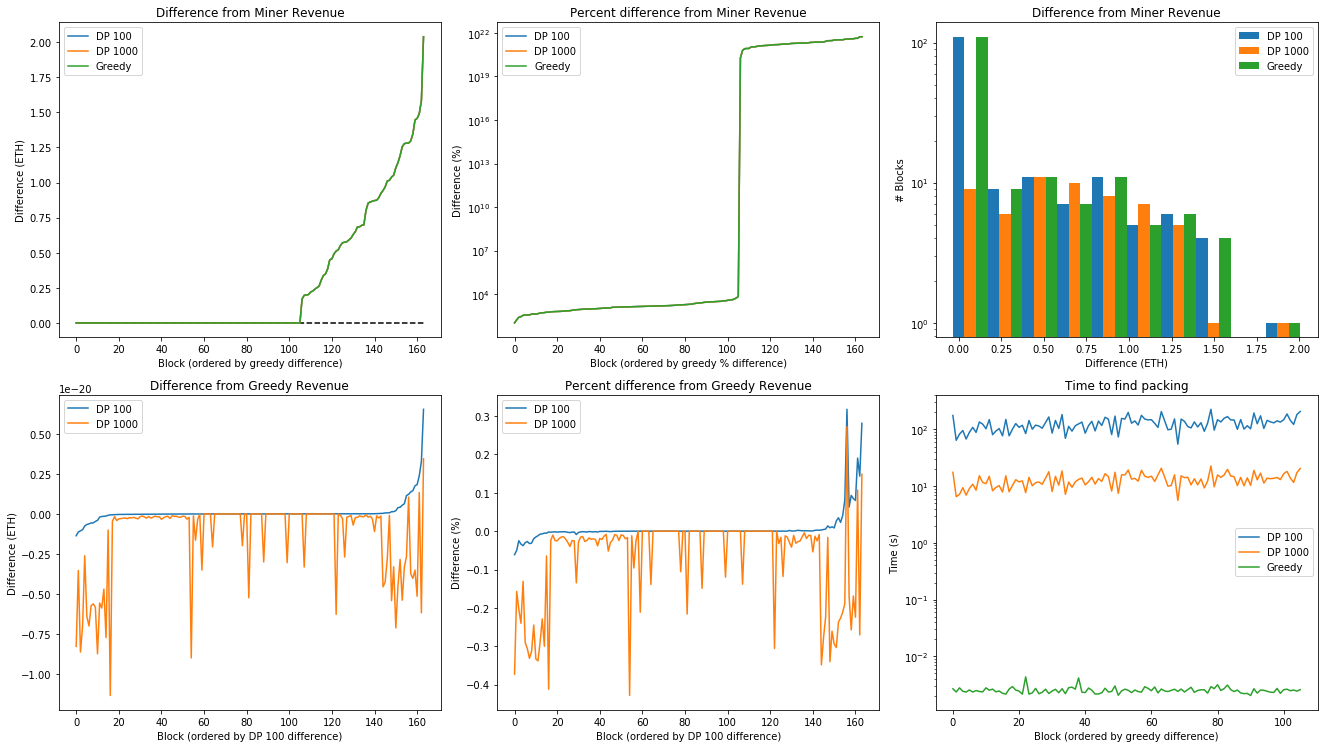

In [14]:
plot_block_comparison(results)

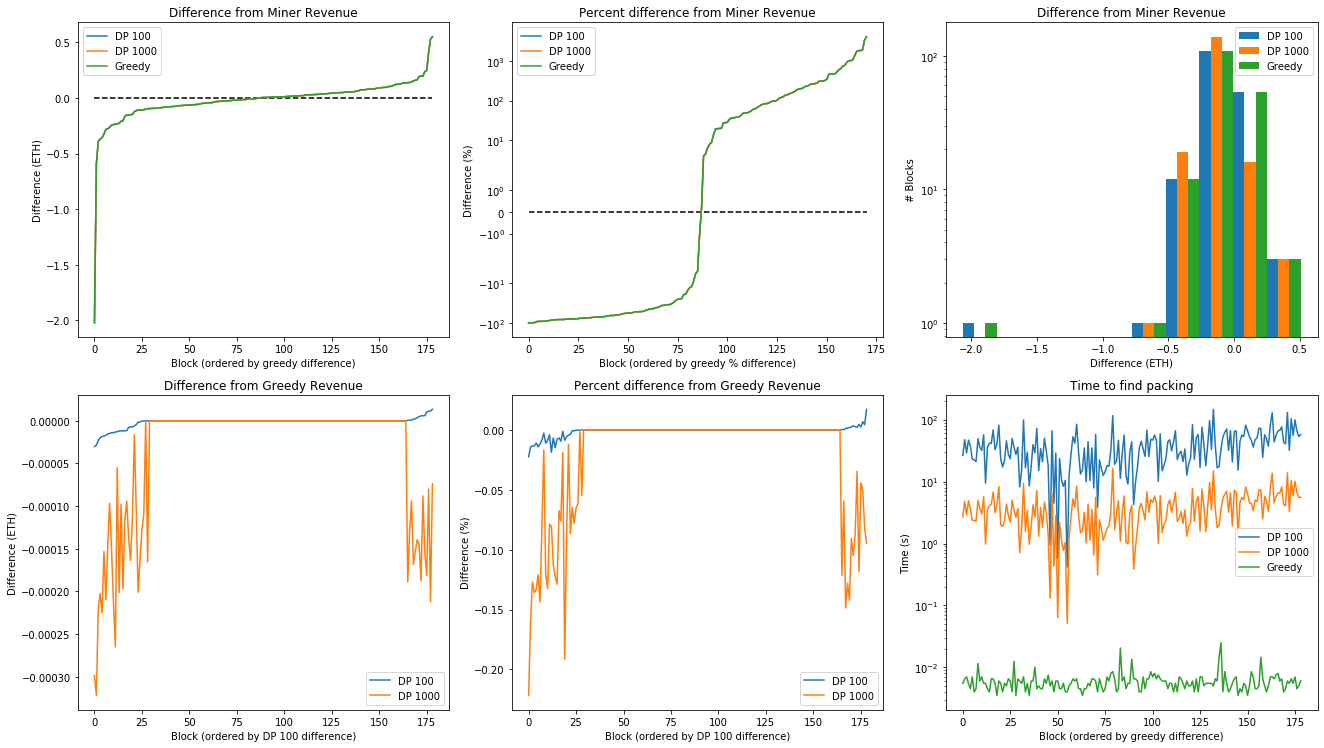

In [66]:
plot_block_comparison(results)

In [60]:
DP_pct = [(r['DP'][100]['value'] - r['greedy']['value'])/r['greedy']['value']*100 for r in results.values()]
sorted(DP_pct, reverse=True)

[0.017318335332565424,
 0.006923534987326477,
 0.004679573991585068,
 0.004432957534977744,
 0.003618020372872179,
 0.0027434055358538712,
 0.0025694564910257924,
 0.002415602457349528,
 0.002305464154002943,
 0.0022069836291406146,
 0.0015353979509829902,
 0.001359899711352239,
 0.0003737976686315278,
 0.00027245342475102534,
 9.159232912870318e-14,
 7.115096998475954e-14,
 5.511875261399565e-14,
 5.23559705794032e-14,
 5.047296694738931e-14,
 4.740770306335934e-14,
 4.424596623033868e-14,
 4.3654528324412226e-14,
 4.3500030368812206e-14,
 4.1842094455542955e-14,
 3.3489932707809894e-14,
 3.070294529334663e-14,
 2.280019092433292e-14,
 2.175933475128523e-14,
 1.995163492767882e-14,
 1.9392696530545323e-14,
 1.8639545758765742e-14,
 1.842489911921851e-14,
 1.816387115805146e-14,
 1.7712750608598437e-14,
 1.7494602661064932e-14,
 1.713621553618821e-14,
 1.703722260013215e-14,
 1.703169542361303e-14,
 1.6209718404781732e-14,
 1.6013957398776117e-14,
 1.4983243855096588e-14,
 1.4191939285

In [67]:
np.mean(DP_pct)

-0.000947091195469573

In [33]:
txs = get_pending_txs(pending_blocks[95])
sorted(txs, key = lambda x: x[1]*x[2], reverse=True)

[('0x98b8253cfd335d1992f5b636b467dce319bd60edb063718ce5d62cbdcc85fb37',
  549183068360.0,
  900000),
 ('0xcc6e2ec36b23c095921e16e378afe4194e15bf6ca4064eaee37768bbd9328914',
  461534012507.0,
  900000),
 ('0x6e13cff681f8186c949134e9489cffdf8f01ff65e11e073f8d450a30f2a528c1',
  334976099340.0,
  900000),
 ('0x39dcc62ba79155fa4158412e4ef87646b20241834e85f5abfaa2539f3f0c38e3',
  238648113641.0,
  900000),
 ('0x16b4eacb253ebe769ae6b3dbd58d528ca7164a27500a6fccda5e2418f7bb0f19',
  120000000000.0,
  1675556.0),
 ('0x333cdb58371c92c8fb945480b5349e6042db4cf622b1a022dca1b729b14d2202',
  180515800922.0,
  900000),
 ('0x09dcc7ab887222394a47e749619b5406b24f8ea969fd3efe74273282c094ecdd',
  464117789394.0,
  257602),
 ('0x315325e0b766af767bf3cb7eb5bcdccb0389c7fcdfed2b5ff238beddd357afd3',
  120000000000.0,
  900000),
 ('0x4c8cc3c0e814f7d5d76487dd7cd5cf2dba01d2994070b7672b4adcca339e8976',
  120000000000.0,
  900000),
 ('0xb971141dca92a10361fcf1e7d59f3e813cad0957831ffbde2542bd9b52d2f35f',
  120000000000.0

Text(0, 0.5, '# Blocks')

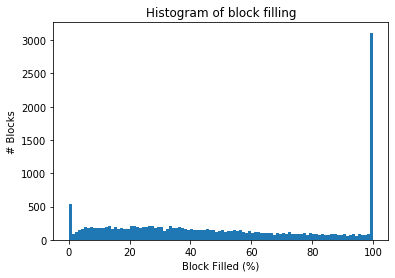

In [68]:
res = query('SELECT gasLimit, gasUsed, 100.0*gasUsed/gasLimit, gasLimit-gasUsed FROM blocks')
plt.hist([x[2] for x in res], bins=100)
plt.title('Histogram of block filling')
plt.xlabel('Block Filled (%)')
plt.ylabel('# Blocks')

In [57]:
sorted(res, reverse=True, key=lambda x: x[1])

[(30117324, 30111651, 99.98116366513838, 5673),
 (30117353, 30108194, 99.9695889608891, 9159),
 (30117296, 30104355, 99.957031335084, 12941),
 (30117353, 30101274, 99.94661217405128, 16079),
 (30087943, 30087355, 99.9980457288157, 588),
 (30087857, 30086183, 99.99443629368486, 1674),
 (30087972, 30085953, 99.99328967735013, 2019),
 (30087972, 30084414, 99.9881746765784, 3558),
 (30087915, 30084299, 99.98798188575047, 3616),
 (30087943, 30083392, 99.9848743398643, 4551),
 (30087915, 30082278, 99.98126490320116, 5637),
 (30087972, 30081808, 99.97951340821508, 6164),
 (30087944, 30080592, 99.97556496382737, 7352),
 (30087972, 30079936, 99.9732916528904, 8036),
 (30087972, 30079068, 99.97040677916078, 8904),
 (30087857, 30077186, 99.96453386494093, 10671),
 (30087943, 30076232, 99.96107743224587, 11711),
 (30087859, 30076197, 99.9612401799676, 11662),
 (30087943, 30075630, 99.95907663079527, 12313),
 (30087972, 30074325, 99.95464300485257, 13647),
 (30087943, 30074008, 99.95368576708617, 1

In [30]:
weight_factors = [100, 1000, 10000]
greedy_val = np.array([r['greedy']['value'] for r in results.values()])
miner_val = np.array([r['miner']['value'] for r in results.values()])
DP_val = np.array([r['DP'][min(weight_factors)]['value'] for r in results.values()])

greedy_val = greedy_val[miner_val > 0]
DP_val = DP_val[miner_val > 0]
miner_val = miner_val[miner_val > 0]
greedy_diff = greedy_val - miner_val
greedy_pct = (greedy_val - miner_val)/miner_val

In [127]:
pending_txs = get_pending_txs(15173461)
DP_packing(pending_txs, 15173461, 10000, True)

 21%|██        | 52/252 [00:00<00:00, 259.23it/s]

Finding best packing with 252 txs for weight limit 2999 (weight reduction factor 10000)


100%|██████████| 252/252 [00:00<00:00, 311.52it/s]


Packed 252 txs in 0.84s for revenue of 0.11611 ETH (-34.05% increase over 0.17606 ETH), using 21521027.0 of max 29999972 gas (wasted 8478945.0 gas, i.e., 28.26%)


[('0xfbf7f24c2e05bfbf090b02e0da25fbdbc3a3b9552830fca6604a95981065d080',
  190966000000000.0,
  1000000000.0,
  190966.0),
 ('0xf55820379c23e9752604d6b3938ceea85cbeeeaf2c174f3f55302ab4c282b987',
  162820000000000.0,
  1000000000.0,
  162820.0),
 ('0xe62f5def4ec83141ebf805830b5a4718eac2e7e595abe8c27b386a8f24e072d5',
  190966000000000.0,
  1000000000.0,
  190966.0),
 ('0xde26767e97e6396d8b01a28911a0a02f2b0e48d2ebd3267c912c18db4947e047',
  65625000000000.0,
  1000000000.0,
  65625.0),
 ('0xdb3f5d7ce17c006225355220681ce5a7d29b68c877178f79db430619ad680dd1',
  21000000000000.0,
  1000000000.0,
  21000.0),
 ('0xcaa3b7628a9f095aec5481dde15fde830e909dc7aa31a20a34ef0863c95981ce',
  21000000000000.0,
  1000000000.0,
  21000.0),
 ('0xc782c13f947944fe06852bcbb344610f5143273d2d6e09adb1101d9ee8bcec49',
  21000000000000.0,
  1000000000.0,
  21000.0),
 ('0xb48f61a6311601814b0d955e309e9d8b3894fdc686ae98d95f132be0c5812b11',
  190966000000000.0,
  1000000000.0,
  190966.0),
 ('0xa083c4ee10a572e9cbf284579ec

In [181]:
# Determine how many transactions in each mined block were ever seen as pending transactions
seen_pending = query(f'''WITH block_nums AS (
                    SELECT DISTINCT lastBlock
                    FROM pending_txs
                        INNER JOIN blocks
                        ON pending_txs.lastBlock = blocks.blockNumber),
                stage_txs AS (
                    SELECT *
                    FROM txs
                    WHERE blockNumber IN block_nums)
                SELECT blockNumber, COUNT(DISTINCT stage_txs.hash)
                FROM stage_txs
                    JOIN pending_txs
                    ON stage_txs.hash = pending_txs.hash
                WHERE lastBlock <= blockNumber
                GROUP BY blockNumber
                ORDER BY blockNumber''')

all_confirmed = query(f'''WITH block_nums AS (
                    SELECT DISTINCT lastBlock
                    FROM pending_txs
                        INNER JOIN blocks
                        ON pending_txs.lastBlock = blocks.blockNumber),
                stage_txs AS (
                    SELECT *
                    FROM txs
                    WHERE blockNumber IN block_nums)
                SELECT blockNumber, COUNT(DISTINCT stage_txs.hash)
                FROM stage_txs
                GROUP BY blockNumber
                ORDER BY blockNumber''')

# Populate seen and unseen transactions from mined blocks
for (block_num, num_confirmed) in all_confirmed:
    results[block_num]['num_real_txs'] = num_confirmed
    
for (block_num, num_seen) in seen_pending:
    results[block_num]['num_seen_real'] = num_seen
    
# If we didn't have a value, enter zero
for block_num in results.keys():
    if 'num_real_txs' not in results[block_num]:
        results[block_num]['num_real_txs'] = 0
    if 'num_seen_real' not in results[block_num]:
        results[block_num]['num_seen_real'] = 0

In [29]:
for block_number, v in results.items():
    # Determine which transactions were actually packed in this block, and how many were ever available
    # as pending transactions
    real_txs = query(f'SELECT DISTINCT hash, gasUsed, gasPrice FROM txs WHERE blockNumber = {block_number}')
    v['num_real_txs'] = len(real_txs)
    seen_txs = query(f'''SELECT DISTINCT txs.hash, txs.gasUsed
                         FROM txs
                             JOIN pending_txs
                             ON txs.hash = pending_txs.hash
                         WHERE blockNumber = {block_number}
                         AND lastBlock <= {block_number}''')
    v['num_seen_real'] = len(seen_txs)
    
    # Percentage of transactions that were never in pending pool
    v['pct_seen_txs'] = 0 if len(real_txs) == 0 else len(seen_txs) / len(real_txs) * 100
    
    # Percentage of the total weight of this block that is filled by transactions that were
    # never in the pending pool
    weight_in_pool = sum([s[1] for s in seen_txs])
    total_weight = sum([r[1] for r in real_txs])
    v['pct_seen_by_weight'] = 0 if total_weight == 0 else weight_in_pool / total_weight * 100
    
    # Revenue earned in this block that came from transactions that were never in the pending pool
    seen_set = set([s[0] for s in seen_txs])
    v['revenue_from_seen'] = sum([r[1] * r[2] if r[0] in seen_set else 0 for r in real_txs])
    v['revenue_from_unseen'] = sum([r[1] * r[2] if r[0] not in seen_set else 0 for r in real_txs])

Text(0.5, 1.0, 'Greedy-miner revenue difference vs. revenue from unseen transactions')

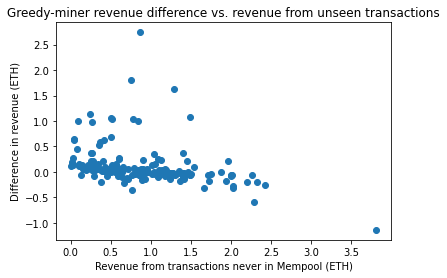

In [16]:
scatter_x = []
scatter_y = []
for v in results.values():
    if v['num_real_txs'] > 0:
        scatter_x.append(v['revenue_from_unseen'] * 1e-18)
        scatter_y.append(v['DP'][100]['value'] - v['miner']['value'])
plt.scatter(scatter_x, scatter_y)
plt.xlabel('Revenue from transactions never in Mempool (ETH)')
plt.ylabel('Difference in revenue (ETH)')
plt.title('Greedy-miner revenue difference vs. revenue from unseen transactions')

In [166]:
block_num = 15173261
res = query(f'SELECT DISTINCT hash FROM pending_txs WHERE lastBlock<={block_num}')
lst = [r[0] for r in res]
len(lst)
res_txs = query(f'SELECT DISTINCT hash FROM txs WHERE blockNumber={block_num}')
txs_lst = [r[0] for r in res_txs]
len(set(txs_lst).intersection(lst))

190

In [147]:
res = query(f'''SELECT lastBlock, COUNT(*)
                FROM pending_txs
                GROUP BY lastBlock
                ORDER BY lastBlock''')
res

[(15167472, 1282),
 (15167535, 678),
 (15167750, 384),
 (15168115, 185),
 (15168621, 590),
 (15169250, 245),
 (15170077, 233),
 (15171056, 1328),
 (15173222, 497),
 (15173227, 152),
 (15173231, 126),
 (15173234, 72),
 (15173236, 51),
 (15173237, 106),
 (15173241, 135),
 (15173246, 92),
 (15173247, 81),
 (15173249, 181),
 (15173252, 154),
 (15173259, 36),
 (15173260, 446),
 (15173261, 383),
 (15173263, 74),
 (15173264, 120),
 (15173265, 146),
 (15173266, 210),
 (15173269, 92),
 (15173272, 202),
 (15173274, 374),
 (15173276, 95),
 (15173278, 467),
 (15173281, 415),
 (15173282, 540),
 (15173283, 422),
 (15173284, 577),
 (15173287, 231),
 (15173291, 138),
 (15173295, 125),
 (15173296, 220),
 (15173300, 71),
 (15173305, 82),
 (15173306, 70),
 (15173307, 94),
 (15173308, 507),
 (15173314, 261),
 (15173315, 317),
 (15173316, 452),
 (15173321, 327),
 (15173322, 586),
 (15173324, 286),
 (15173329, 199),
 (15173330, 544),
 (15173331, 521),
 (15173333, 495),
 (15173335, 402),
 (15173339, 193),
 (

In [107]:
res = query('SELECT lastBlock, category, COUNT(*) FROM pending_txs_raw GROUP BY lastBlock, category')
res

[(15167472, 'baseFee', 30000),
 (15167472, 'pending', 1301),
 (15167472, 'queued', 26712),
 (15167535, 'baseFee', 30000),
 (15167535, 'pending', 748),
 (15167535, 'queued', 26006),
 (15167750, 'baseFee', 30000),
 (15167750, 'pending', 417),
 (15167750, 'queued', 25254),
 (15168115, 'baseFee', 30000),
 (15168115, 'pending', 227),
 (15168115, 'queued', 24942),
 (15168621, 'baseFee', 30000),
 (15168621, 'pending', 633),
 (15168621, 'queued', 25011),
 (15169250, 'baseFee', 30000),
 (15169250, 'pending', 300),
 (15169250, 'queued', 25551),
 (15170077, 'baseFee', 30000),
 (15170077, 'pending', 283),
 (15170077, 'queued', 25933),
 (15171056, 'baseFee', 30000),
 (15171056, 'pending', 1420),
 (15171056, 'queued', 26406),
 (15173222, 'baseFee', 60000),
 (15173222, 'pending', 861),
 (15173222, 'queued', 51546),
 (15173227, 'baseFee', 30000),
 (15173227, 'pending', 182),
 (15173227, 'queued', 25757),
 (15173231, 'baseFee', 30000),
 (15173231, 'pending', 159),
 (15173231, 'queued', 25749),
 (151732

In [103]:
hash_val = 0x711E007309c9b7661e0Da3B15f800bdC37D4F742
res = query(f'SELECT pending_txs_raw.*, baseFeePerGas FROM pending_txs_raw LEFT JOIN blocks ON lastBlock=blockNumber WHERE hash="0xb4120e9d405a26045ecdb2a8229e91af57f6c8ad4075611eb45f7f9e7331eb6e" AND lastBlock={block_number}')
res

[(None,
  None,
  1109305553375.0,
  21000,
  '0xb4120e9d405a26045ecdb2a8229e91af57f6c8ad4075611eb45f7f9e7331eb6e',
  15167472,
  0,
  'queued',
  '0x711E007309c9b7661e0Da3B15f800bdC37D4F742',
  '0x238',
  72036856407)]

In [63]:
res = query('WITH top AS (SELECT *, ROW_NUMBER() OVER (PARTITION BY lastBlock) AS row_num FROM pending_txs_raw) SELECT * FROM top WHERE row_num<=10')
res

[('0x929b46fe6217c2e79d50ee07f3d64b09680ab6930571fe64c3096f1322fe903a',
  15167472,
  '0x00000014fB27C20091312322533b51Da81e500fa',
  '0xba',
  433779,
  3266405075.0,
  1),
 ('0x0adcc0a60d2b60bca6424813d3bfabce50fc9532d1b6031516bb0386cfc7e3ba',
  15167472,
  '0x0000008ffe90b2e7a3f7035152B65ABE6B70D7dA',
  '0x233',
  4417184,
  3500006095.0,
  2),
 ('0x482bda774c527776466b46111c637a538f7455236ea95f3d24009397e4cb3ca8',
  15167472,
  '0x000000C124f7728795C5A39B3Aae7672f2a62F25',
  '0x3a',
  104874,
  2454390315.0,
  3),
 ('0xbcfd8e9fbbc59e16695ce0a2a3dfc3c96c0b14244413251225361e834eaa6b4e',
  15167472,
  '0x000002cAA224B3465f64feF897a5b67d004bfE61',
  '0x30c2',
  233038,
  2805300000.0,
  4),
 ('0x60acbf10ebbe70ba9bee5d971516afdca72f47ae7efefc6a297b3630eb4fab23',
  15167472,
  '0x0000046F12583Ae04e754FE831Ea4dB644794c4F',
  '0x3153',
  233038,
  2812500000.0,
  5),
 ('0xbc9b77a72b66fcadb2b8eec3b05e41756e82e9e81d0fa34656b6b43de06156e3',
  15167472,
  '0x000007B9FE2608dd8e9949cEaAA96a362ED

In [69]:
res = query('SELECT hash, gasPrice - baseFeePerGas FROM pending_txs_raw LEFT JOIN blocks ON lastBlock = blockNumber WHERE gasPrice IS NULL LIMIT 20')
res

[('0x66153fdba0ca8fab6464c30feffdc3a232e3dc362d7ebf73462cdc2de66ea42c', None),
 ('0xf12525300437d30fce839a5576ce25a16dd75ea835a5ba78bf9fe16b70e07f05', None),
 ('0xd6301770a263e30a7ab46fb93f098087710b2fe68b0993492e0eed89c426e733', None),
 ('0x5c2b4377932cb7aeafc35d866fd834e26935c5537e9015922968c22a13786e78', None),
 ('0x38e4399309cb4d8663d8a9cdfb942df5d706d0a2a30aecc3525053718ef0f334', None),
 ('0x112e4f4fdc3cab9ebc80bc14e2764b4d09a69b88d13850ef9bf2b7445c221aa5', None),
 ('0xb9a106acb54f320b10200ad4b04bad6f26b3495a6cf2069b5b7ead0b7cd46611', None),
 ('0x9a22634fc80abaea706131d68386e564beefe08246b5dd99c6d99a52e66a8611', None),
 ('0x112cbac845d87ec58270ced8183c7b11db5506e91f97b61db01efbe89f26c004', None),
 ('0x4a70b575a27b344a2d7dbb919a3612321718960b769197538ae9d5d9517ca3ed', None),
 ('0x1451d7bf44dc80a3f65c8fc1016f61879d0521371ec0c73e95bd30cf49ce159f', None),
 ('0x925eb2afeaee54a9aa629afa45dde7b709b84430ac90541e1ad327d6a15df8c1', None),
 ('0xa0ebf4b1a335dc7179ad140344897c04dc6a69f88984881

In [104]:
res = query('with test as(SELECT distinct * FROM pending_txs_raw WHERE lastBlock = 15173222) select count(*) from test')
res

[(56351,)]